# CS6140 Final Project: Fake News Detection
## Part 1: Data Preprocessing & Exploratory Data Analysis

**Team Members**: <br>
Yu Ma: Data Acqusitions, Preprocessing and Exploratory Data Analysis (EDA);<br>
Zhixuan Shen;<br>
Ziyue Shen; <br>
Yaohui Wang  


In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [64]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

print("✓ NLTK data downloaded!")

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# For better display in Jupyter
%matplotlib inline

✓ NLTK data downloaded!


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/freyama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/freyama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/freyama/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Data Loading 

In [42]:
# File paths - UPDATE THESE TO YOUR LOCAL PATHS
FAKE_PATH = 'Fake.csv'
TRUE_PATH = 'True.csv'

print("Dataset paths:")
print(f"  Fake news: {FAKE_PATH}")
print(f"  True news: {TRUE_PATH}")

# Load fake news dataset
df_fake = pd.read_csv(FAKE_PATH)
df_fake['label'] = 0  # 0 for fake
print(f"✓ Loaded {len(df_fake):,} fake news articles")
print(f"  Columns: {list(df_fake.columns)}")

# Load true news dataset
df_true = pd.read_csv(TRUE_PATH)
df_true['label'] = 1  # 1 for true
print(f"✓ Loaded {len(df_true):,} true news articles")
print(f"  Columns: {list(df_true.columns)}")

# Combine both datasets
df_raw = pd.concat([df_fake, df_true], axis=0, ignore_index=True)
print(f"\n✓ Combined dataset: {len(df_raw):,} total articles")
print(f"  Shape: {df_raw.shape}")

Dataset paths:
  Fake news: Fake.csv
  True news: True.csv
✓ Loaded 23,481 fake news articles
  Columns: ['title', 'text', 'subject', 'date', 'label']
✓ Loaded 21,417 true news articles
  Columns: ['title', 'text', 'subject', 'date', 'label']

✓ Combined dataset: 44,898 total articles
  Shape: (44898, 5)


### Initial Data Inspection

In [17]:
# Display first few rows
print("First 3 rows of the dataset:")
df_raw.head(3)

# Dataset information
print("Dataset Info:")
df_raw.info()

# Class distribution
print("Class Distribution:")
print(df_raw['label'].value_counts())
print(f"\nFake (0): {(df_raw['label']==0).sum():,} ({(df_raw['label']==0).sum()/len(df_raw)*100:.2f}%)")
print(f"True (1): {(df_raw['label']==1).sum():,} ({(df_raw['label']==1).sum()/len(df_raw)*100:.2f}%)")

# Check for missing values
print("Missing Values:")
missing = df_raw.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal missing values: {df_raw.isnull().sum().sum()}")

# Subject distribution
print("Subject Distribution:")
print(df_raw['subject'].value_counts())

First 3 rows of the dataset:
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
Class Distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Fake (0): 23,481 (52.30%)
True (1): 21,417 (47.70%)
Missing Values:
Series([], dtype: int64)

Total missing values: 0
Subject Distribution:
subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


In [18]:
# Sample articles
print("Sample Fake News Article:")
print("="*80)
fake_sample = df_raw[df_raw['label']==0].iloc[0]
print(f"Title: {fake_sample['title']}")
print(f"Text: {fake_sample['text'][:300]}...")
print(f"Subject: {fake_sample['subject']}")
print(f"Date: {fake_sample['date']}")

print("\n" + "="*80)
print("Sample True News Article:")
print("="*80)
true_sample = df_raw[df_raw['label']==1].iloc[0]
print(f"Title: {true_sample['title']}")
print(f"Text: {true_sample['text'][:300]}...")
print(f"Subject: {true_sample['subject']}")
print(f"Date: {true_sample['date']}")

Sample Fake News Article:
Title:  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Text: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger a...
Subject: News
Date: December 31, 2017

Sample True News Article:
Title: As U.S. budget fight looms, Republicans flip their fiscal script
Text: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way ...
Subject: politicsNews
Date: December 31, 2017 


## Data Preprocessing 

### Define Text Cleaning Function

In [44]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text) # Remove email addresses    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("✓ Text cleaning function defined")

# Test the cleaning function
test_text = "Check out this article at https://example.com! It's #Amazing... 123"
cleaned = clean_text(test_text)
print(f"Original: {test_text}")
print(f"Cleaned:  {cleaned}")

✓ Text cleaning function defined
Original: Check out this article at https://example.com! It's #Amazing... 123
Cleaned:  check out this article at its amazing


### Handle Missing Values

In [45]:
# Create a copy for processing
df = df_raw.copy()

initial_missing = df['title'].isna().sum() + df['text'].isna().sum()
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')

print(f"✓ Filled {initial_missing} missing values in title and text columns")

✓ Filled 0 missing values in title and text columns


### Combine Title and Text

In [46]:
# Combine title and text
df['full_text'] = df['title'] + ' ' + df['text']
print(f"✓ Created 'full_text' column")
print(f"  Sample length: {len(df['full_text'].iloc[0])} characters")

✓ Created 'full_text' column
  Sample length: 2973 characters


### Clean All Text

In [47]:
print("Cleaning text... (this may take 1-2 minutes)")
df['cleaned_text'] = df['full_text'].apply(clean_text)
print("✓ Text cleaning complete!")

sample_idx = 0
print("Before cleaning:")
print(df['full_text'].iloc[sample_idx][:200])
print("\n" + "="*80 + "\n")
print("After cleaning:")
print(df['cleaned_text'].iloc[sample_idx][:200])

Cleaning text... (this may take 1-2 minutes)
✓ Text cleaning complete!
Before cleaning:
 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out


After cleaning:
donald trump sends out embarrassing new years eve message this is disturbing donald trump just couldn t wish all americans a happy new year and leave it at that instead he had to give a shout out to h


### Remove Stopwords (in case my group mates want to use some tradtional ML models)

In [48]:
REMOVE_STOPWORDS = False  # Set to True if you want to remove stopwords

if REMOVE_STOPWORDS:
    print("Removing stopwords...")
    stop_words = set(stopwords.words('english'))
    
    def remove_stopwords(text):
        if not text:
            return ""
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)
    
    df['processed_text'] = df['cleaned_text'].apply(remove_stopwords)
    print("✓ Stopwords removed")
else:
    df['processed_text'] = df['cleaned_text']
    print("✓ Keeping stopwords (recommended for BERT)")


# Count empty texts
empty_count = (df['processed_text'].str.strip() == '').sum()
print(f"Found {empty_count} empty texts")

# Remove empty texts
df = df[df['processed_text'].str.strip() != '']
df = df.reset_index(drop=True)

print(f"✓ Final dataset size: {len(df):,} articles")

✓ Keeping stopwords (recommended for BERT)
Found 9 empty texts
✓ Final dataset size: 44,889 articles


### Create Additional Features

In [49]:
# Create length features
df['text_length'] = df['processed_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))

print("✓ Created length features:")
print(f"  - text_length: character count")
print(f"  - word_count: word count")

# Process date information
try:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    print("✓ Extracted year and month from dates")
    print(f"  Date range: {df['year'].min()} - {df['year'].max()}")
except:
    print("⚠ Could not parse dates")

# Display processed dataset info
print("\nProcessed Dataset Summary:")
print("="*80)
print(f"Total articles: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nSample statistics:")
print(df[['text_length', 'word_count', 'label']].describe())

✓ Created length features:
  - text_length: character count
  - word_count: word count
✓ Extracted year and month from dates
  Date range: 2015.0 - 2017.0

Processed Dataset Summary:
Total articles: 44,889
Columns: ['title', 'text', 'subject', 'date', 'label', 'full_text', 'cleaned_text', 'processed_text', 'text_length', 'word_count', 'year', 'month']

Sample statistics:
        text_length    word_count         label
count  44889.000000  44889.000000  44889.000000
mean    2447.602999    411.499610      0.477110
std     2089.860428    346.886631      0.499481
min       22.000000      3.000000      0.000000
25%     1261.000000    212.000000      0.000000
50%     2180.000000    369.000000      0.000000
75%     3057.000000    518.000000      1.000000
max    50182.000000   8057.000000      1.000000


---
## Exploratory Data Analysis - EDS

### Class Distribution

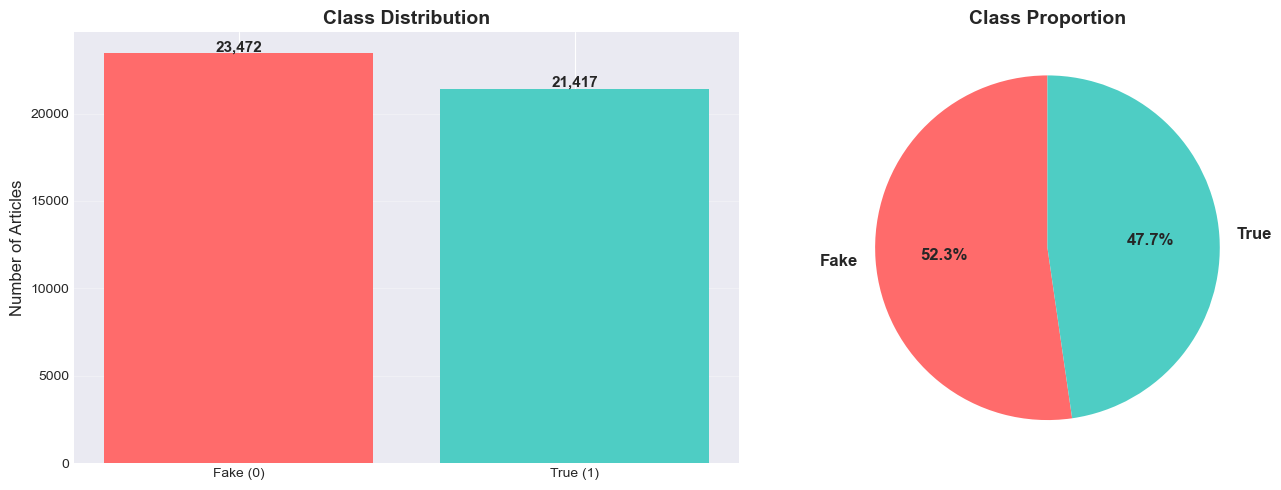

✓ Figure saved: fig1_class_distribution.png
Dataset is balanced


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
counts = df['label'].value_counts()
axes[0].bar(['Fake (0)', 'True (1)'], counts.values, color=['#FF6B6B', '#4ECDC4'])
axes[0].set_ylabel('Number of Articles', fontsize=12)
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold', fontsize=11)

# Pie chart
colors = ['#FF6B6B', '#4ECDC4']
axes[1].pie(counts.values, labels=['Fake', 'True'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('fig1_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved: fig1_class_distribution.png")
print(f"Dataset is {'balanced' if abs(counts[0]-counts[1])/len(df) < 0.1 else 'imbalanced'}")

### Text Length Analysis

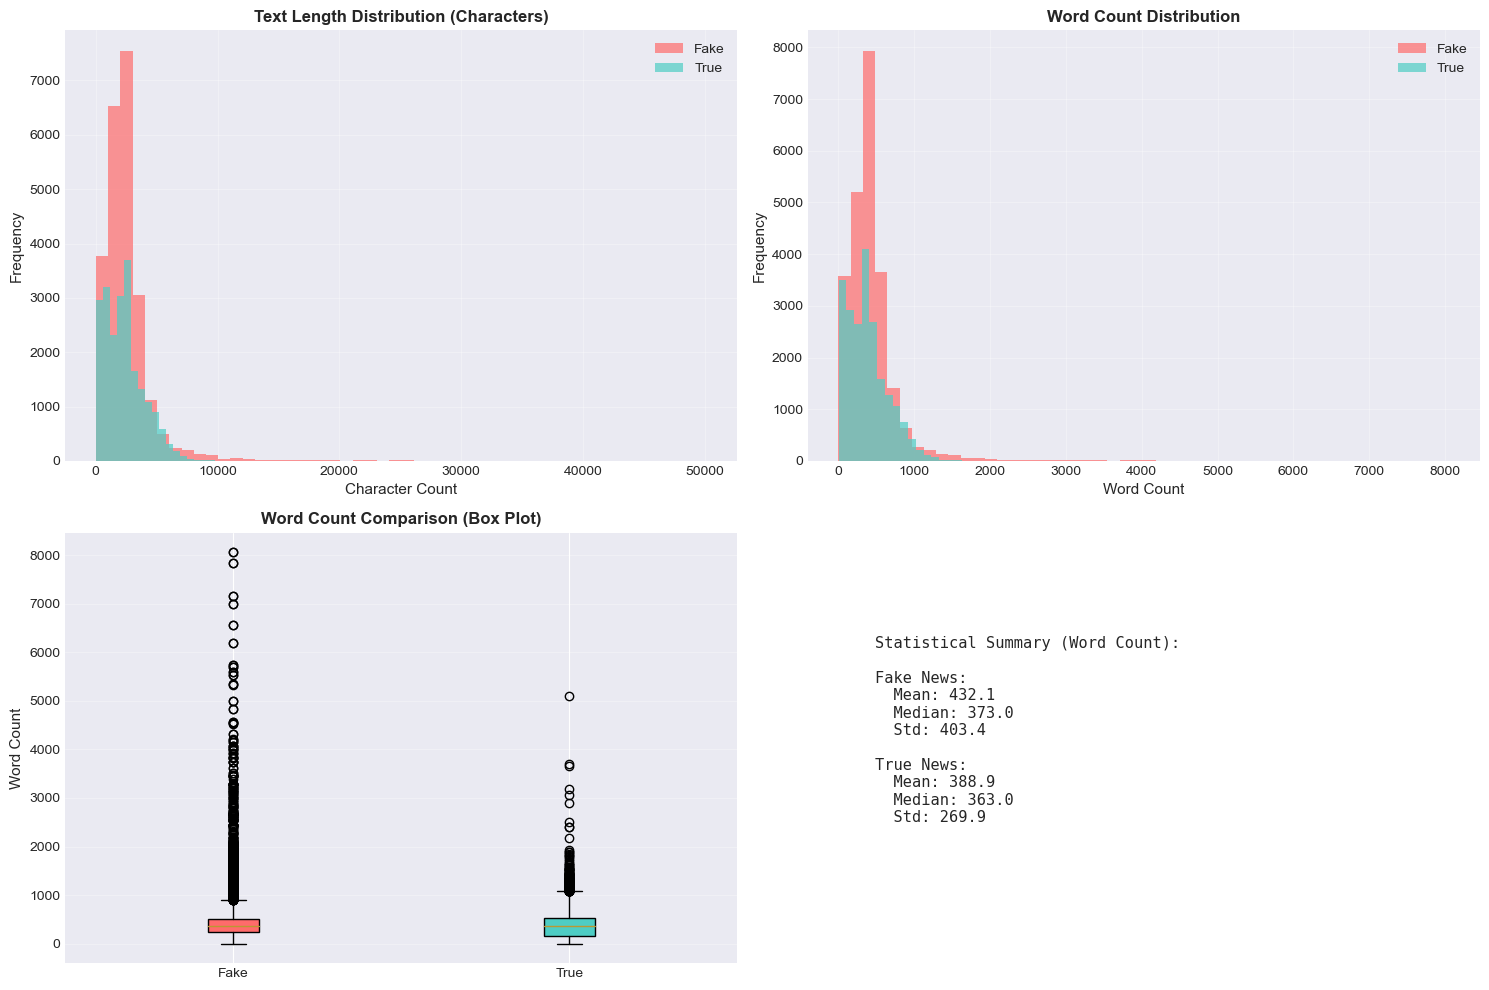

✓ Figure saved: fig2_text_length.png
Fake news avg: 432.1 words
True news avg: 388.9 words
Difference: 43.1 words


In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Character length distribution by class
axes[0, 0].hist(df[df['label']==0]['text_length'], bins=50, 
               alpha=0.7, label='Fake', color='#FF6B6B')
axes[0, 0].hist(df[df['label']==1]['text_length'], bins=50, 
               alpha=0.7, label='True', color='#4ECDC4')
axes[0, 0].set_xlabel('Character Count', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Text Length Distribution (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# 2. Word count distribution by class
axes[0, 1].hist(df[df['label']==0]['word_count'], bins=50, 
               alpha=0.7, label='Fake', color='#FF6B6B')
axes[0, 1].hist(df[df['label']==1]['word_count'], bins=50, 
               alpha=0.7, label='True', color='#4ECDC4')
axes[0, 1].set_xlabel('Word Count', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# 3. Box plot comparison
data_to_plot = [df[df['label']==0]['word_count'],
               df[df['label']==1]['word_count']]
bp = axes[1, 0].boxplot(data_to_plot, labels=['Fake', 'True'], patch_artist=True)
bp['boxes'][0].set_facecolor('#FF6B6B')
bp['boxes'][1].set_facecolor('#4ECDC4')
axes[1, 0].set_ylabel('Word Count', fontsize=11)
axes[1, 0].set_title('Word Count Comparison (Box Plot)', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Statistical summary
stats_text = "Statistical Summary (Word Count):\n\n"
for label, name in [(0, 'Fake'), (1, 'True')]:
    data = df[df['label']==label]['word_count']
    stats_text += f"{name} News:\n"
    stats_text += f"  Mean: {data.mean():.1f}\n"
    stats_text += f"  Median: {data.median():.1f}\n"
    stats_text += f"  Std: {data.std():.1f}\n\n"

axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
               verticalalignment='center')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('fig2_text_length.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved: fig2_text_length.png")
fake_mean = df[df['label']==0]['word_count'].mean()
true_mean = df[df['label']==1]['word_count'].mean()
print(f"Fake news avg: {fake_mean:.1f} words")
print(f"True news avg: {true_mean:.1f} words")
print(f"Difference: {abs(fake_mean-true_mean):.1f} words")

### Subject Distribution

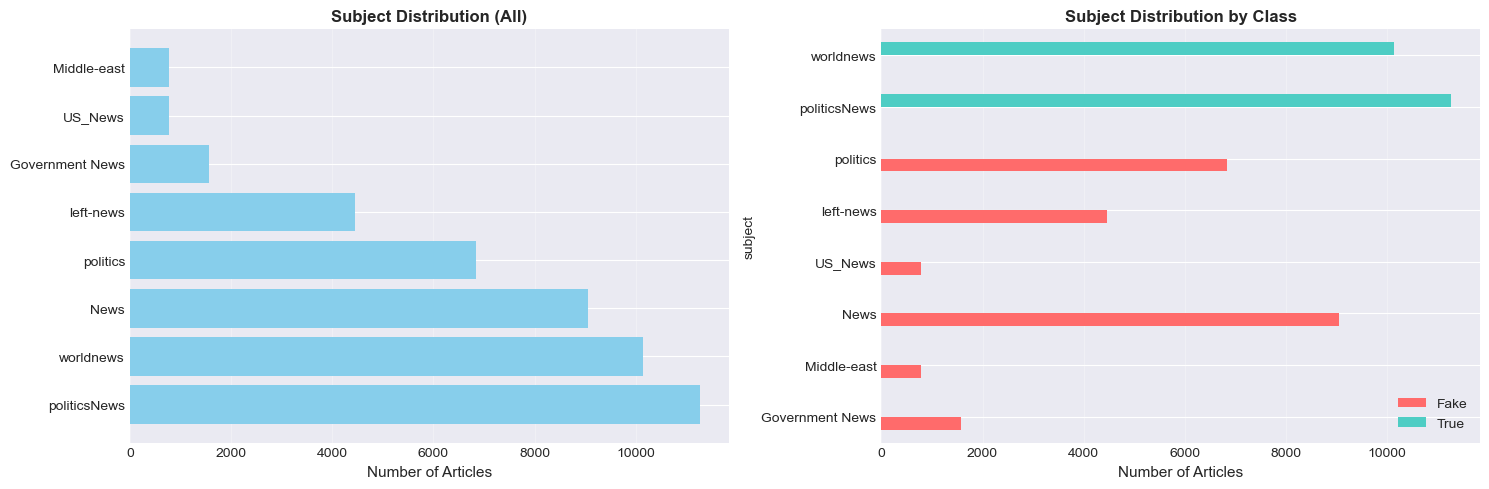

✓ Figure saved: fig3_subject_distribution.png
Found 8 different subjects
Most common: politicsNews (11,272 articles)


In [32]:
if 'subject' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Overall subject distribution
    subject_counts = df['subject'].value_counts()
    axes[0].barh(subject_counts.index, subject_counts.values, color='skyblue')
    axes[0].set_xlabel('Number of Articles', fontsize=11)
    axes[0].set_title('Subject Distribution (All)', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Subject distribution by class
    subject_by_label = pd.crosstab(df['subject'], df['label'])
    subject_by_label.plot(kind='barh', stacked=False, ax=axes[1], 
                         color=['#FF6B6B', '#4ECDC4'])
    axes[1].set_xlabel('Number of Articles', fontsize=11)
    axes[1].set_title('Subject Distribution by Class', fontsize=12, fontweight='bold')
    axes[1].legend(['Fake', 'True'], fontsize=10)
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fig3_subject_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Figure saved: fig3_subject_distribution.png")
    print(f"Found {len(subject_counts)} different subjects")
    print(f"Most common: {subject_counts.index[0]} ({subject_counts.values[0]:,} articles)")
else:
    print("⚠ No 'subject' column found")

### Temporal Analysis

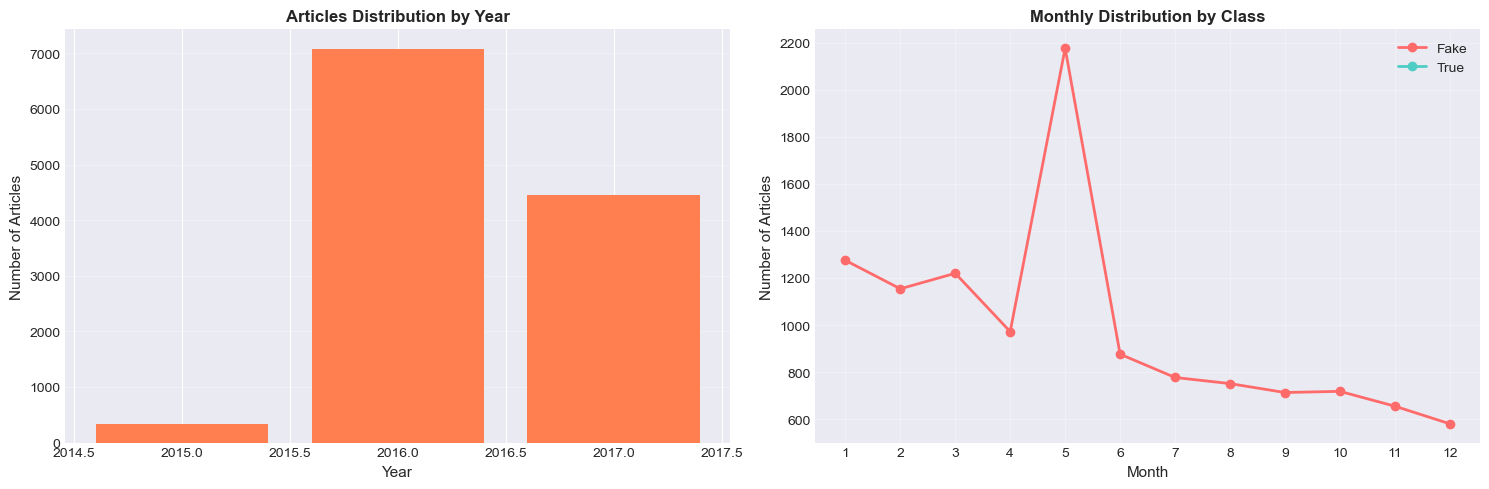

✓ Figure saved


In [50]:
if 'year' in df.columns and 'month' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Articles by year
    year_counts = df['year'].value_counts().sort_index()
    axes[0].bar(year_counts.index, year_counts.values, color='coral')
    axes[0].set_xlabel('Year', fontsize=11)
    axes[0].set_ylabel('Number of Articles', fontsize=11)
    axes[0].set_title('Articles Distribution by Year', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Articles by month (for each class)
    for label, color, name in [(0, '#FF6B6B', 'Fake'), (1, '#4ECDC4', 'True')]:
        month_data = df[df['label']==label]['month'].value_counts().sort_index()
        axes[1].plot(month_data.index, month_data.values, marker='o', 
                    label=name, color=color, linewidth=2)
    
    axes[1].set_xlabel('Month', fontsize=11)
    axes[1].set_ylabel('Number of Articles', fontsize=11)
    axes[1].set_title('Monthly Distribution by Class', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)
    axes[1].set_xticks(range(1, 13))
    
    plt.tight_layout()
    plt.savefig('fig4_temporal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Figure saved")
else:
    print("⚠ No date information available")

### Word Clouds

Generating word clouds... (this may take 1-2 minutes)


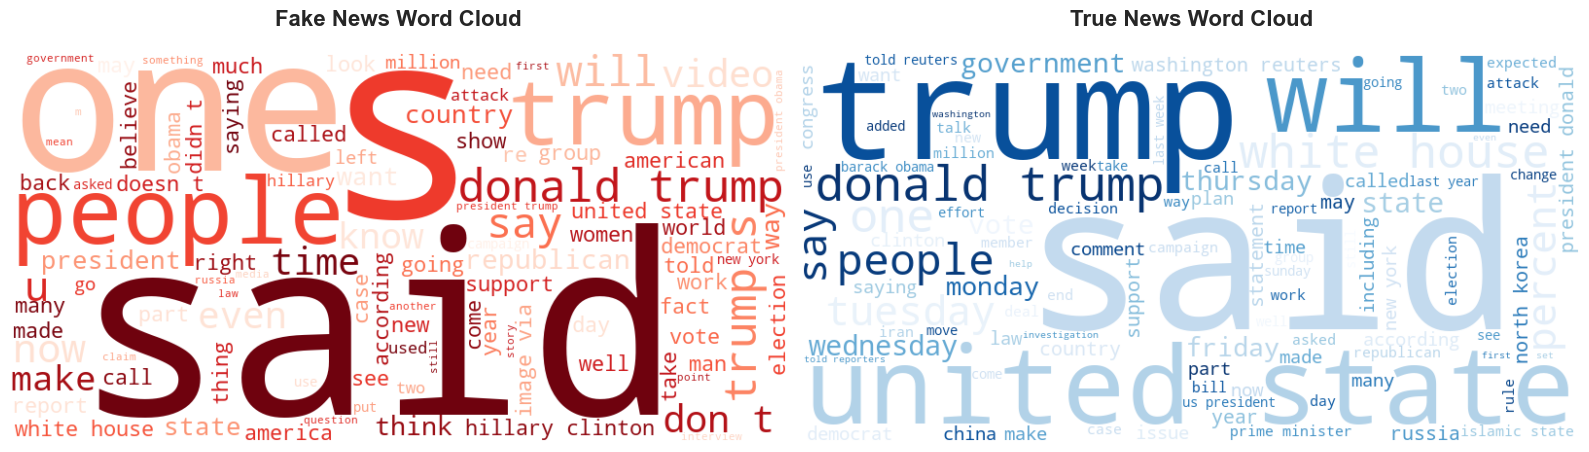

✓ Figure saved


In [51]:
print("Generating word clouds... (this may take 1-2 minutes)")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fake news word cloud
fake_text = ' '.join(df[df['label']==0]['processed_text'].values)
wordcloud_fake = WordCloud(width=800, height=400, 
                           background_color='white',
                           colormap='Reds',
                           max_words=100).generate(fake_text)

axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Fake News Word Cloud', fontsize=16, fontweight='bold', pad=20)

# True news word cloud
true_text = ' '.join(df[df['label']==1]['processed_text'].values)
wordcloud_true = WordCloud(width=800, height=400, 
                           background_color='white',
                           colormap='Blues',
                           max_words=100).generate(true_text)

axes[1].imshow(wordcloud_true, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('True News Word Cloud', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('fig5_wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Figure saved")

### Top Words Analysis

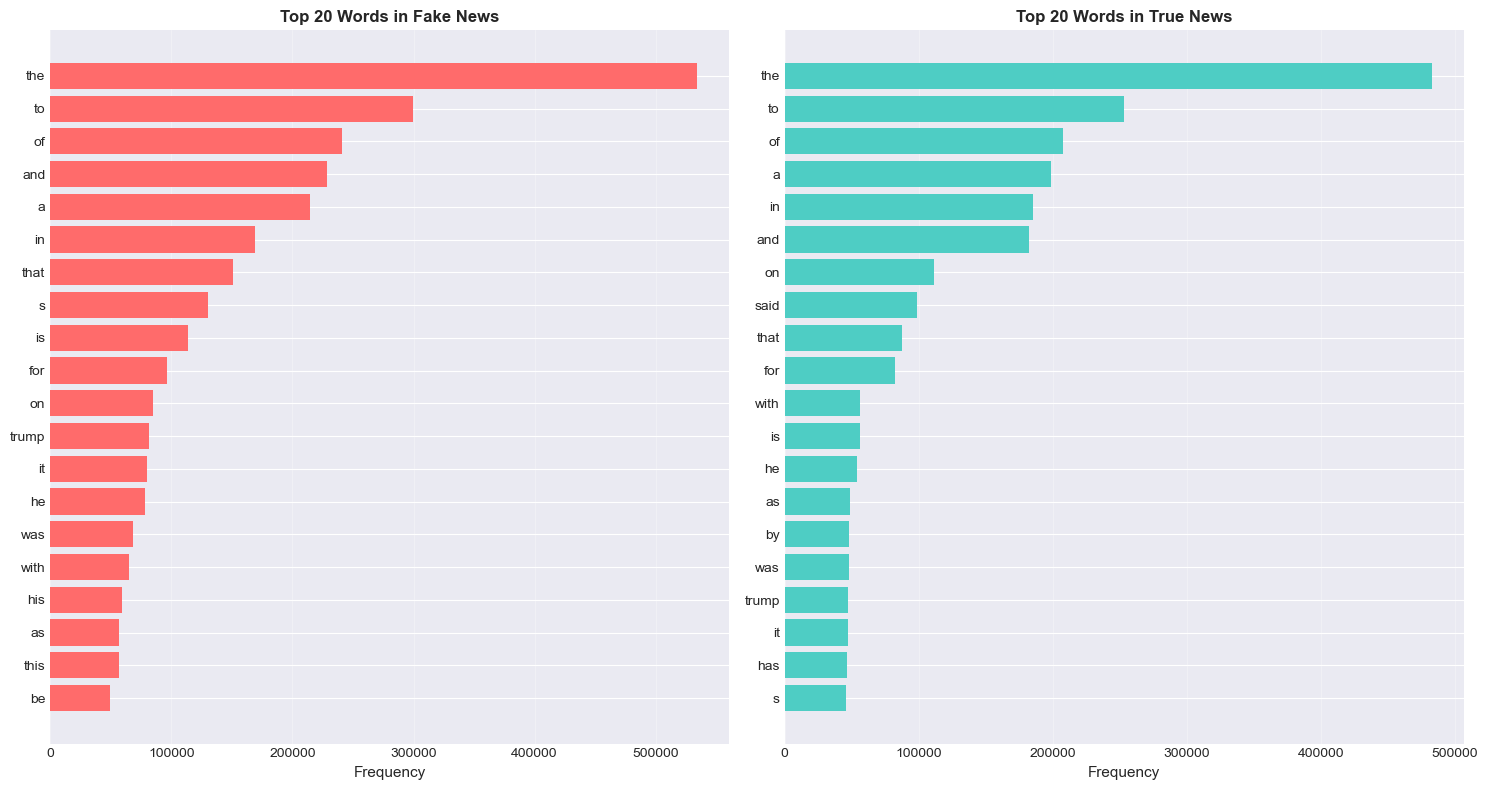

In [52]:
n_words = 20
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

for idx, (label, color, name) in enumerate([(0, '#FF6B6B', 'Fake'), 
                                              (1, '#4ECDC4', 'True')]):
    text_data = df[df['label']==label]['processed_text']
    all_words = ' '.join(text_data.values).split()
    word_freq = Counter(all_words)
    
    # Get top N words
    top_words = word_freq.most_common(n_words)
    words, counts = zip(*top_words)
    
    axes[idx].barh(range(len(words)), counts, color=color)
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words, fontsize=10)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Top {n_words} Words in {name} News', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('fig6_top_words.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlation Analysis

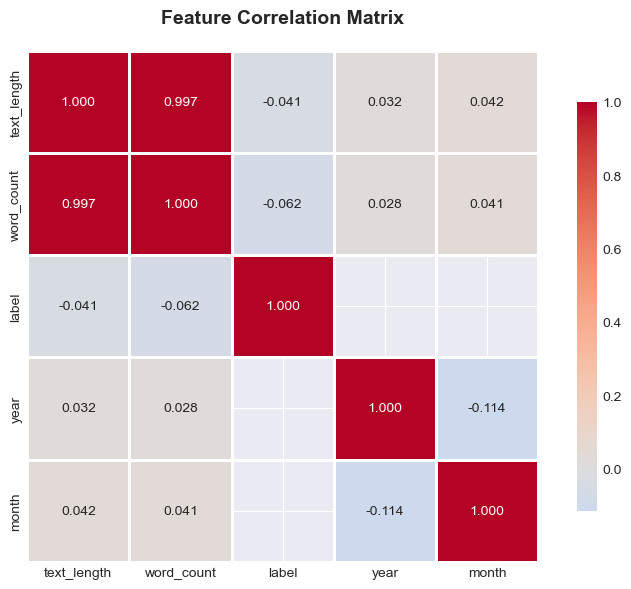

In [54]:
numerical_cols = ['text_length', 'word_count', 'label']
if 'year' in df.columns:
    numerical_cols.append('year')
if 'month' in df.columns:
    numerical_cols.append('month')

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
           center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('fig7_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


### Summary Statistics Report

In [58]:
print(" Summary Statistics Report".center(80, "="))

print("\n1. Dataset Overview")
print(f"   Total articles: {len(df):,}")
print(f"   Fake articles: {(df['label']==0).sum():,} ({(df['label']==0).sum()/len(df)*100:.2f}%)")
print(f"   True articles: {(df['label']==1).sum():,} ({(df['label']==1).sum()/len(df)*100:.2f}%)")

print("\n2. Text Length Statistics")
for label, name in [(0, 'Fake'), (1, 'True')]:
    data = df[df['label']==label]
    print(f"\n   {name} News:")
    print(f"      Avg characters: {data['text_length'].mean():.1f}")
    print(f"      Avg words: {data['word_count'].mean():.1f}")
    print(f"      Min words: {data['word_count'].min()}")
    print(f"      Max words: {data['word_count'].max()}")

if 'subject' in df.columns:
    print("\n3. subjext distrubution")
    subject_counts = df['subject'].value_counts()
    for subject, count in subject_counts.items():
        print(f"   {subject}: {count:,} ({count/len(df)*100:.1f}%)")

if 'year' in df.columns:
    print("\n4. Temporal Coverage")
    print(f"   Year range: {df['year'].min():.0f} - {df['year'].max():.0f}")
    print(f"   Most articles in: {df['year'].mode()[0]:.0f}")


=========================== Summary Statistics Report===========================

1. Dataset Overview
   Total articles: 44,889
   Fake articles: 23,472 (52.29%)
   True articles: 21,417 (47.71%)

2. Text Length Statistics

   Fake News:
      Avg characters: 2529.5
      Avg words: 432.1
      Min words: 3
      Max words: 8057

   True News:
      Avg characters: 2357.8
      Avg words: 388.9
      Min words: 4
      Max words: 5105

3. subjext distrubution
   politicsNews: 11,272 (25.1%)
   worldnews: 10,145 (22.6%)
   News: 9,050 (20.2%)
   politics: 6,836 (15.2%)
   left-news: 4,457 (9.9%)
   Government News: 1,568 (3.5%)
   US_News: 783 (1.7%)
   Middle-east: 778 (1.7%)

4. Temporal Coverage
   Year range: 2015 - 2017
   Most articles in: 2016


---
## Feature Engineering for later ML models 

### Prepare Data for Traditional ML Models (TF-IDF)

In [ ]:
print("Preparing data for TF-IDF models...")
X_tfidf = df['processed_text'].values
y = df['label'].values
print(f"✓ X shape: {X_tfidf.shape}, y shape: {y.shape}")

print("Preparing data for BERT...")
X_bert = df['cleaned_text'].values
y_bert = df['label'].values
print(f"✓ X shape: {X_bert.shape}, y shape: {y_bert.shape}")

Preparing data for TF-IDF models...
✓ X shape: (44889,), y shape: (44889,)
Preparing data for BERT...
✓ X shape: (44889,), y shape: (44889,)


### Create Train/Test Split

In [60]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"Creating train/test split (test_size={TEST_SIZE})...")

# For TF-IDF models
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("\nTraditional ML (TF-IDF):")
print(f"  ✓ Training set: {len(X_train_tfidf):,} samples")
print(f"  ✓ Test set: {len(X_test_tfidf):,} samples")
print(f"  ✓ Train class distribution: Fake={sum(y_train==0):,}, True={sum(y_train==1):,}")
print(f"  ✓ Test class distribution: Fake={sum(y_test==0):,}, True={sum(y_test==1):,}")

# For BERT model
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert, y_bert, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_bert
)

print("\nBERT Model:")
print(f"  ✓ Training set: {len(X_train_bert):,} samples")
print(f"  ✓ Test set: {len(X_test_bert):,} samples")
print(f"  ✓ Train class distribution: Fake={sum(y_train_bert==0):,}, True={sum(y_train_bert==1):,}")
print(f"  ✓ Test class distribution: Fake={sum(y_test_bert==0):,}, True={sum(y_test_bert==1):,}")

Creating train/test split (test_size=0.2)...

Traditional ML (TF-IDF):
  ✓ Training set: 35,911 samples
  ✓ Test set: 8,978 samples
  ✓ Train class distribution: Fake=18,777, True=17,134
  ✓ Test class distribution: Fake=4,695, True=4,283

BERT Model:
  ✓ Training set: 35,911 samples
  ✓ Test set: 8,978 samples
  ✓ Train class distribution: Fake=18,777, True=17,134
  ✓ Test class distribution: Fake=4,695, True=4,283


## Save Outputs
Save processed data and prepared datasets for modeling.

In [62]:
# Save processed dataframe
output_file = 'processed_fake_news_data.csv'
df.to_csv(output_file, index=False)
print(f"✓ Processed data saved to: {output_file}")
print(f"  File size: {df.shape[0]:,} rows × {df.shape[1]} columns")

# 这个你们不要的话 告诉我 我删掉
# Optional: Save train/test splits as pickle files for easy loading
import pickle

# Save for traditional ML
with open('train_test_tfidf.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train_tfidf,
        'X_test': X_test_tfidf,
        'y_train': y_train,
        'y_test': y_test
    }, f)
print("✓ TF-IDF train/test data saved to: train_test_tfidf.pkl")

# Save for BERT
with open('train_test_bert.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train_bert,
        'X_test': X_test_bert,
        'y_train': y_train_bert,
        'y_test': y_test_bert
    }, f)
print("✓ BERT train/test data saved to: train_test_bert.pkl")

✓ Processed data saved to: processed_fake_news_data.csv
  File size: 44,889 rows × 12 columns
✓ TF-IDF train/test data saved to: train_test_tfidf.pkl
✓ BERT train/test data saved to: train_test_bert.pkl
